## Python for Finance 8 - Modern Portfolio Theory

In [33]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

#### Dates & Other Constants

In [34]:
# Define path to files
PATH = "../data/stock-list/"

# Start date defaults
S_YEAR = 2017
S_MONTH = 1
S_DAY = 1
S_DATE_STR = "2017-01-01"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End date defaults
E_YEAR = 2021
E_MONTH = 12
E_DAY = 31
E_DATE_STR = "2021-12-31"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

risk_free_rate = 0.0125 # Approximate 10 year bond rate

#### Get Stock File Names in a List

In [35]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers

tickers.sort()
len(tickers)

2862

#### Function that Returns a Dataframe from a CSV

In [36]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

#### Merge Multiple Stocks in One Dataframe by Column Name

In [37]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

#### Markowitz Portfolio Optimization

Harry Markowitz proved that you could make what is called an efficient portfolio. That is a portfolio that optimizes return while also minimizing risk. We don't benefit from analyzing individual securities at the same rate as if we instead considered a portfolio of stocks.

We do this by creating portfolios with stocks that are not correlated. We want to calculate expected returns by analyzing the returns of each stock multiplied by its weight.

$w_1r_1 + w_2r_2 = r_p$

The standard deviation of the portfolio is found this way. Sum multiple calculations starting by finding the product of the first securities weight squared times its standard deviation squared. The middle is 2 times the correlation coefficient between the stocks. And, finally add those to the weight squared times the standard deviation squared for the second security.

$(w_1 \sigma_1 + w_2 \sigma_2)^2 = w_1^2 \sigma_1^2 + 2w_1 \sigma_1w_2 \sigma_2 \rho_1 + w_2^2 \sigma_2^2$

#### Plotting an Efficient Frontier

#### Stock Portfolio

In [38]:
# Here I added the top 30 for each sector. You can obviously add as many as 
# you like
# Then to keep the portfolio smaller I eliminated stocks that had an 
# allocation less than 1% to get this final list
# I showed in part 4 of this series how to get the top sector stocks
port_list = ["GNRC", "CPRT", "ODFL", 
            "AMD", "PAYC",
            "CHTR",
            "EL", "MKC",
            "PGR",
            "NEM",
            "CCI",
            "NFLX"]
num_stocks = len(port_list)
num_stocks

12

#### Merge all Stock Price Data

In [39]:
mult_df = merge_df_by_column_name('Adj Close',  '2018-01-01', 
                                  '2021-09-01', *port_list)
mult_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,EL,MKC,PGR,NEM,CCI,NFLX
Date,,,,,,,,,,,,
2018-01-02,48.029999,43.599998,88.318527,10.980000,80.440002,348.970001,122.982391,47.579830,46.956577,34.035385,95.263092,201.070007
2018-01-03,49.730000,43.389999,88.410500,11.550000,81.029999,353.029999,124.939072,47.692631,46.931133,33.749969,94.860786,205.050003
2018-01-04,50.070000,43.740002,88.929497,12.120000,83.110001,349.790009,125.527054,47.993431,46.922642,34.124580,93.758881,205.630005
2018-01-05,50.410000,43.529999,89.737526,11.880000,83.879997,350.880005,125.295700,48.463455,47.100765,34.249447,94.476021,209.990005
2018-01-08,49.529999,43.549999,90.630966,12.280000,84.639999,356.549988,126.240273,48.515160,47.244965,34.213772,94.755852,212.050003
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26,427.470001,142.970001,286.100006,107.269997,481.149994,797.400024,334.677338,84.243729,94.632889,55.548443,187.006393,550.119995
2021-08-27,437.109985,144.440002,289.779999,111.400002,484.700012,807.179993,338.984039,84.531387,95.871979,57.078644,188.228592,558.919983
2021-08-30,442.700012,144.449997,293.839996,111.320000,488.850006,814.200012,342.161804,84.759529,94.554222,56.411633,189.549362,566.179993


#### Plot Growth of Investment over Total Dataset

<AxesSubplot:xlabel='Date'>

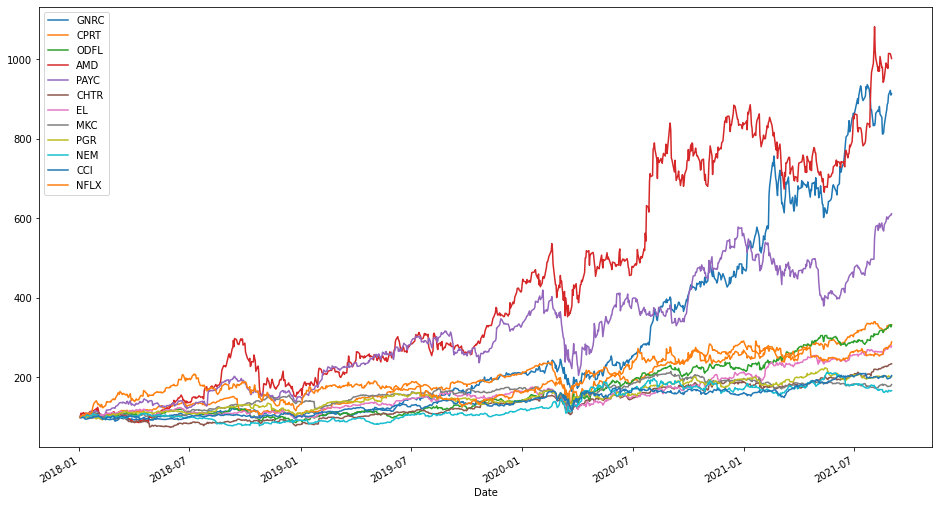

In [40]:
(mult_df / mult_df.iloc[0] * 100).plot(figsize=(16, 9))

#### Mean Returns

In [41]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean() * 252 # 252 average trading days per year
mean_ret

GNRC    0.603930
CPRT    0.327972
ODFL    0.327313
AMD     0.629130
PAYC    0.494435
CHTR    0.232728
EL      0.280027
MKC     0.163806
PGR     0.191840
NEM     0.139702
CCI     0.195734
NFLX    0.290206
dtype: float64

#### Covariance

In [42]:
returns.cov() * 252

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,EL,MKC,PGR,NEM,CCI,NFLX
GNRC,0.158177,0.062339,0.060455,0.086634,0.086730,0.043115,0.049192,0.034057,0.041879,0.025441,0.044316,0.051509
CPRT,0.062339,0.099872,0.051417,0.067348,0.086944,0.038190,0.049405,0.029281,0.031825,0.017813,0.035088,0.040910
ODFL,0.060455,0.051417,0.101327,0.065634,0.063132,0.035213,0.048271,0.028706,0.038244,0.016211,0.031079,0.045941
AMD,0.086634,0.067348,0.065634,0.312339,0.116016,0.056724,0.059564,0.036053,0.044064,0.035417,0.043460,0.102219
PAYC,0.086730,0.086944,0.063132,0.116016,0.227547,0.052287,0.068154,0.042660,0.055359,0.022478,0.059203,0.081632
CHTR,0.043115,0.038190,0.035213,0.056724,0.052287,0.084964,0.034096,0.023719,0.029208,0.015086,0.035420,0.046956
EL,0.049192,0.049405,0.048271,0.059564,0.068154,0.034096,0.096501,0.030570,0.035028,0.009694,0.034054,0.039545
MKC,0.034057,0.029281,0.028706,0.036053,0.042660,0.023719,0.030570,0.068122,0.031299,0.019388,0.039424,0.025899
PGR,0.041879,0.031825,0.038244,0.044064,0.055359,0.029208,0.035028,0.031299,0.074192,0.014802,0.035843,0.034033
NEM,0.025441,0.017813,0.016211,0.035417,0.022478,0.015086,0.009694,0.019388,0.014802,0.107000,0.020577,0.014270


#### Correlation

In [43]:
returns.corr()

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,EL,MKC,PGR,NEM,CCI,NFLX
GNRC,1.000000,0.495985,0.477524,0.389768,0.457155,0.371910,0.398161,0.328088,0.386587,0.195553,0.400948,0.314748
CPRT,0.495985,1.000000,0.511118,0.381318,0.576739,0.414583,0.503250,0.354993,0.369710,0.172317,0.399524,0.314604
ODFL,0.477524,0.511118,1.000000,0.368937,0.415765,0.379507,0.488160,0.345510,0.441080,0.155690,0.351323,0.350744
AMD,0.389768,0.381318,0.368937,1.000000,0.435181,0.348203,0.343086,0.247161,0.289465,0.193732,0.279824,0.444497
PAYC,0.457155,0.576739,0.415765,0.435181,1.000000,0.376047,0.459931,0.342646,0.426060,0.144058,0.446592,0.415886
CHTR,0.371910,0.414583,0.379507,0.348203,0.376047,1.000000,0.376552,0.311768,0.367882,0.158216,0.437258,0.391495
EL,0.398161,0.503250,0.488160,0.343086,0.459931,0.376552,1.000000,0.377044,0.413967,0.095400,0.394469,0.309370
MKC,0.328088,0.354993,0.345510,0.247161,0.342646,0.311768,0.377044,1.000000,0.440255,0.227085,0.543524,0.241148
PGR,0.386587,0.369710,0.441080,0.289465,0.426060,0.367882,0.413967,0.440255,1.000000,0.166131,0.473504,0.303654
NEM,0.195553,0.172317,0.155690,0.193732,0.144058,0.158216,0.095400,0.227085,0.166131,1.000000,0.226359,0.106018


#### Generate Random Weight Equal to 1

In [44]:
# Generate 12 random values that sum to 1
weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print('Weights :', weights)
print('Total Weight :', np.sum(weights))

Weights : [0.11110183 0.06703508 0.12307452 0.10461246 0.02695281 0.14434419
 0.02030648 0.02571835 0.00708078 0.11984121 0.10596802 0.14396427]
Total Weight : 1.0000000000000002


#### Calculating Return of Portfolio

In [45]:
# Provide return of portfolio using random weights over the whole dataset
np.sum(weights * returns.mean()) * 252

0.3326219421960327

#### Calculating Volatility

In [46]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

0.2316552006337385

#### Analyzing Returns & Risk of 10000 Combinations

In [47]:
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list


for x in range(10000):
    # Generate random weights
    p_weights = np.random.random(num_stocks)
    p_weights /= np.sum(p_weights)
    
    # Add return using those weights to list
    ret_1 = np.sum(p_weights * returns.mean()) * 252
    p_ret.append(ret_1)
    
    # Add volatility or standard deviation to list
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)
    
    # Get Sharpe ratio
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)
    
    # Store the weights for each portfolio
    p_wt.append(p_weights)
    
# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

(array([0.33316472, 0.31839284, 0.26574883, ..., 0.3726989 , 0.30057359,
        0.28017522]),
 array([0.24107735, 0.225786  , 0.20226925, ..., 0.24864631, 0.22757649,
        0.21034925]),
 array([1.3301321 , 1.35479103, 1.25203819, ..., 1.44863961, 1.26583197,
        1.27252756]),
 array([[0.05520495, 0.03518492, 0.06600731, ..., 0.07024674, 0.10785678,
         0.14650523],
        [0.11700402, 0.10562792, 0.02168293, ..., 0.08992977, 0.08810346,
         0.07128449],
        [0.06403573, 0.05533234, 0.07157918, ..., 0.15869398, 0.09196538,
         0.05187143],
        ...,
        [0.11158804, 0.1446163 , 0.12474187, ..., 0.12473171, 0.0413289 ,
         0.03302754],
        [0.00210431, 0.07924548, 0.07374637, ..., 0.01341304, 0.10754038,
         0.03149056],
        [0.01447454, 0.0720401 , 0.1204737 , ..., 0.09760473, 0.10171487,
         0.07020616]]))

#### Plotting the Efficient Frontier

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

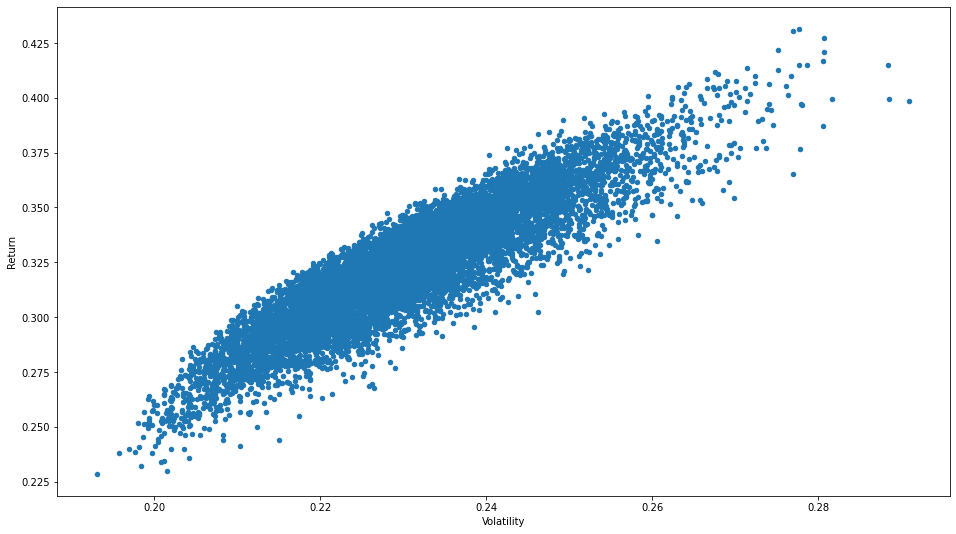

In [48]:
# Create a dataframe with returns and volatility
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})

ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(16, 9))

#### Sharpe Ratio

People want to maximize returns while avoiding as much risk as possible. William Sharpe created the Sharpe Ratio to find the portfolio that provides the best return for the lowest amount of risk.

*Sharpe Ratio* = $ \frac{r_i - r_f}{\sigma_i}$

$r_f = $ Risk Free Rate

$r_i = $ Rate of Return of the stock

$\sigma_i = $ Standard Deviation of the Stock

As return increases so does the Sharpe Ratio, but as Standard Deviation increase the Sharpe Ratio decreases.

In [49]:
# Return the index of the largest Sharpe Ratio
SR_idx = np.argmax(p_SR)

# Find the ideal portfolio weighting at that index
i = 0
while i < num_stocks:
    print("Stock : %s : %2.2f" % (port_list[i], (p_wt[SR_idx][i] * 100)))
    i += 1
    
# Find volatility of that portfolio
print("\nVolatility :", p_vol[SR_idx])
      
# Find return of that portfolio
print("Return :", p_ret[SR_idx])

Stock : GNRC : 21.31
Stock : CPRT : 14.79
Stock : ODFL : 10.41
Stock : AMD : 15.05
Stock : PAYC : 2.71
Stock : CHTR : 3.15
Stock : EL : 7.87
Stock : MKC : 14.55
Stock : PGR : 3.61
Stock : NEM : 4.59
Stock : CCI : 1.89
Stock : NFLX : 0.09

Volatility : 0.24926198771469615
Return : 0.38980856968391286


#### Get Number of Shares & Cost Based on Weights

In [50]:
# I'm going to use a similar portfolio that has slightly easier percents to work with

# Calculated Weighting
# Stock : GNRC : 21.31
# Stock : CPRT : 14.79
# Stock : ODFL : 10.41
# Stock : AMD : 15.05
# Stock : PAYC : 2.71
# Stock : CHTR : 3.15
# Stock : EL : 7.87
# Stock : MKC : 14.55
# Stock : PGR : 3.61
# Stock : NEM : 4.59
# Stock : CCI : 1.89
# Stock : NFLX : 0.09

_For the Example_

Calculated Weighting
- Stock : GNRC : 21.90 
- Stock : CPRT : 15.63 
- Stock : ODFL : 23.83
- Stock : AMD : 11.09
- Stock : PAYC : 1.86
- Stock : CHTR : 3.55
- Stock : MKC : 2.87
- Stock : PG : 1.09
- Stock : PGR : 2.86
- Stock : NEM : 10.11
- Stock : CCI : 4.34
- Stock : COG : 0.87

Find percentage closest to 1 and use it as the basis for calculating all other shares Since PG is 1% : GNRC is 21.90 : Multiply cost of PG (118.20) by 22 (21.9 Rounded up) and then divide that by the cost of GNRC to get the shares to buy for GNRC

118.20 * 22 = 2,600.4 / 102.01 = 25.49 (25 Shares) 102.01 =

In situations in which prices don't work either discard stock or force 1 share

In [51]:
def get_port_shares(one_price, force_one, wts, prices):
    # Gets number of stocks to analyze
    num_stocks = len(wts)
    
    # Holds the number of shares for each
    shares = []
    
    # Holds Cost of shares for each
    cost_shares = []
    
    i = 0
    while i < num_stocks:
        # Get max amount to spend on stock 
        max_price = one_price * wts[i]
        
        # Gets number of shares to buy and adds them to list
        num_shares = int(max_price / prices[i])
        
        # If the user wants to force buying one share do it
        if(force_one & (num_shares == 0)):
            num_shares = 1
        
        shares.append(num_shares)
        
        # Gets cost of those shares and appends to list
        cost = num_shares * prices[i]
        cost_shares.append(cost)
        i += 1
        
    return shares, cost_shares

#### Get Portfolio Weighting

In [52]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts

#### Returns the Value of Portfolio by Date

In [53]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, 
                                  date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_df_start.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

#### Approximate Portfolio Weighting Based on Request

In [54]:
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", 
             "EL", "PGR", "NEM", "CCI", "NFLX"]

port_wts = [21, 15, 10, 15, 3, 3, 8, 15, 4, 5, 2, 0]

# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Adj Close',  '2020-01-02', 
                                  '2020-01-02', *port_list)
# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()
# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

# Calculated Weighting
# Stock : GNRC : 21.31
# Stock : CPRT : 14.79
# Stock : ODFL : 10.41
# Stock : AMD : 15.05
# Stock : PAYC : 2.71
# Stock : CHTR : 3.15
# Stock : EL : 7.87
# Stock : MKC : 14.55
# Stock : PGR : 3.61
# Stock : NEM : 4.59
# Stock : CCI : 1.89
# Stock : NFLX : 0.09

tot_shares, share_cost = get_port_shares(118.20, True, port_wts, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
get_port_val_by_date('2020-12-31', tot_shares, port_list)

Shares : [24, 18, 9, 36, 1, 1, 11, 8, 7, 14, 1, 1]
Share Cost : [2448.2400512695317, 1682.6400604248047, 1146.2229080200195, 1767.5999450683591, 271.79998779296875, 490.4299926757813, 893.9514999389648, 1624.13720703125, 470.02672576904297, 573.2249221801758, 133.36074829101562, 329.8099975585937]
Total Investment : 11831.444046020508
Stock Weights : [0.2069265629577139, 0.1422176408796658, 0.09687937529532165, 0.1493984959226418, 0.02297268082710397, 0.04145140616548298, 0.07555726050529261, 0.13727294831585046, 0.03972691109730903, 0.04844927803829485, 0.011271722012316101, 0.027875717983006892]


[102.01000213623048,
 93.4800033569336,
 127.35810089111328,
 49.09999847412109,
 271.79998779296875,
 490.4299926757813,
 81.26831817626953,
 203.01715087890625,
 67.14667510986328,
 40.944637298583984,
 133.36074829101562,
 329.8099975585937]